In [1]:
import cv2
import itertools
import numpy as np
from scipy import linalg
import matplotlib as mpl
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from matplotlib.patches import Ellipse
from eye_gaze_data_reader import get_eye_gaze_data

In [43]:
task_name = "cookie"
# task_name = "picnic"

if task_name == "cookie":
    image_path = './images/Cookie_theft_segmentation.png'
else:
    image_path = './images/Picnic_segmentation.png'
    
image = cv2.imread(image_path)

# Convert the image to RGB (OpenCV loads images in BGR format by default)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Reshape the image to a 2D array of pixels
pixels = image_rgb.reshape(-1, 3)

# Use a KD-Tree to find unique colors within a threshold
threshold = 5
tree = cKDTree(pixels)
unique_colors = []
labels = np.zeros(pixels.shape[0], dtype=int) - 1

for i, pixel in enumerate(pixels):
    if labels[i] == -1:
        indices = tree.query_ball_point(pixel, threshold)
        unique_colors.append(pixel)
        labels[indices] = len(unique_colors) - 1

unique_colors = np.array(unique_colors)

# Print unique colors
print(f"Unique colors (within threshold): {unique_colors}")

Unique colors (within threshold): [[  0   0   0]
 [  0   0 255]
 [128   0   0]
 [255 255   0]
 [  0 255 255]
 [128 128   0]
 [255   0 255]
 [  0   0 128]
 [  0 255   0]
 [  0 128   0]]


In [44]:
# Create a dictionary mapping from color tuples to segment labels
color_to_label = {tuple(color): label for label, color in enumerate(unique_colors)}

# Print the mapping
print(f"Color to label mapping: {color_to_label}")


Color to label mapping: {(0, 0, 0): 0, (0, 0, 255): 1, (128, 0, 0): 2, (255, 255, 0): 3, (0, 255, 255): 4, (128, 128, 0): 5, (255, 0, 255): 6, (0, 0, 128): 7, (0, 255, 0): 8, (0, 128, 0): 9}


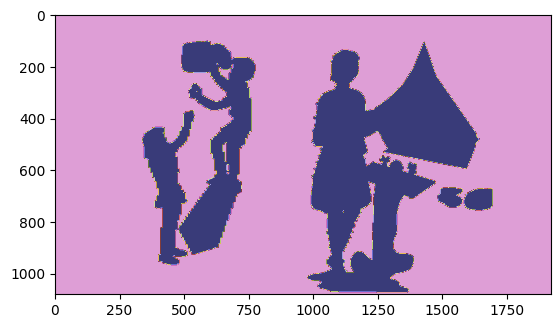

0


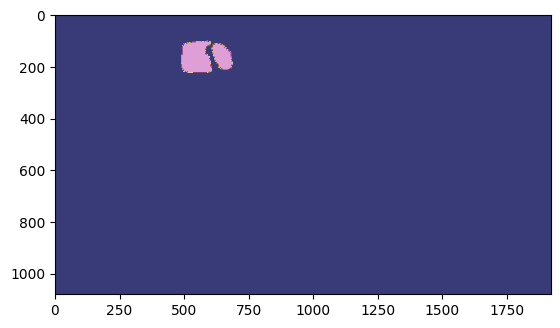

1


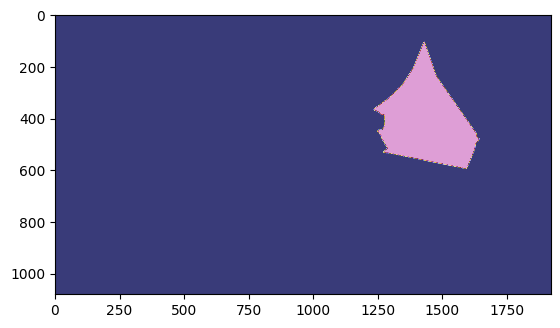

2


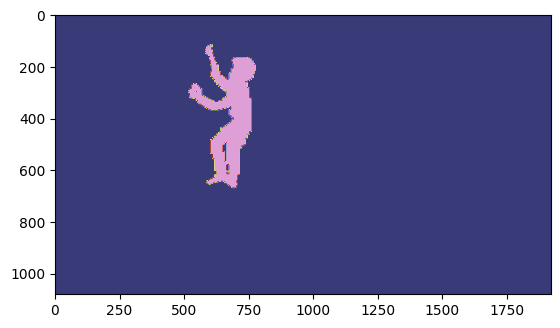

3


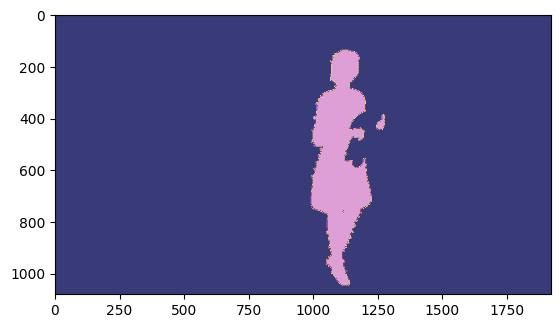

4


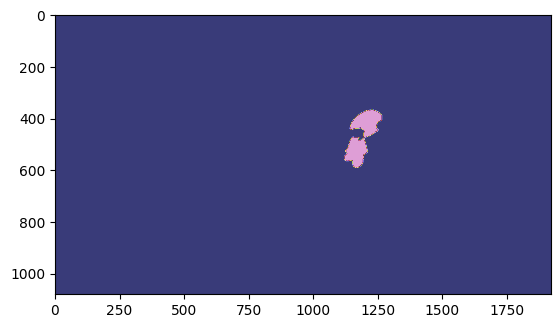

5


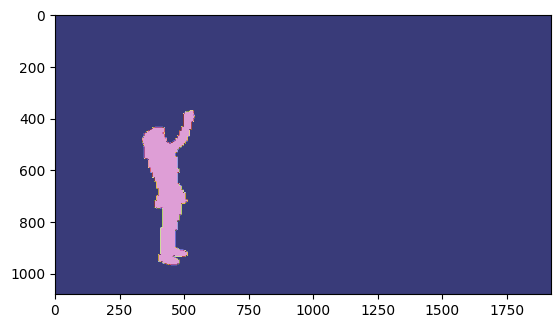

6


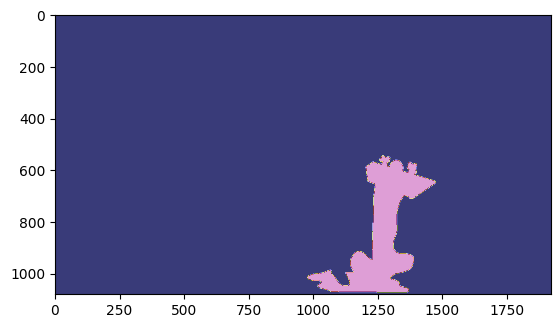

7


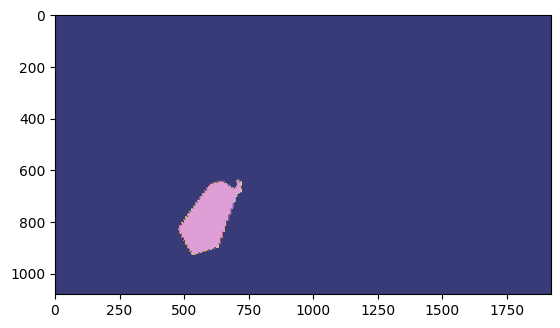

8


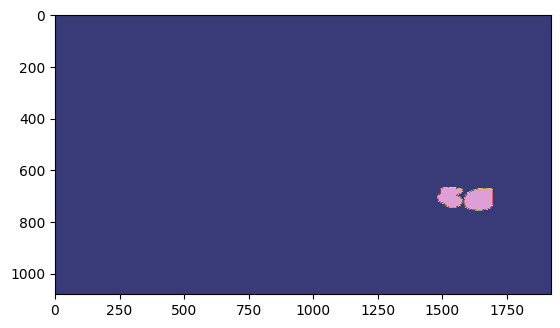

9
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [45]:
# Initialize the segmented mask with the same height and width as the input image
segmented_mask = np.zeros((image_rgb.shape[0], image_rgb.shape[1]), dtype=np.int32)

# Assign labels to each pixel based on the color
for i, color in enumerate(unique_colors):
    mask = np.all(image_rgb==color, axis=-1)
    plt.imshow(mask, cmap='tab20b')
    plt.show()
    print(i)
    segmented_mask[mask] = i

# Print the segmented mask
print(segmented_mask)


(959, 539, (0, 0, 0))
(1261, 842, (128, 0, 0))
(1259, 422, (255, 255, 0))
(1098, 562, (255, 255, 0))
(673, 394, (0, 255, 255))
(434, 654, (255, 0, 255))
(1435, 408, (0, 0, 128))
(594, 786, (0, 255, 0))
(1638, 715, (0, 128, 0))
(1527, 705, (0, 128, 0))
[(959, 539, (0, 0, 0)), (1261, 842, (128, 0, 0)), (1259, 422, (255, 255, 0)), (1098, 562, (255, 255, 0)), (673, 394, (0, 255, 255)), (434, 654, (255, 0, 255)), (1435, 408, (0, 0, 128)), (594, 786, (0, 255, 0)), (1638, 715, (0, 128, 0)), (1527, 705, (0, 128, 0))]
Centroid of color (0, 0, 0): (959, 539)
Centroid of color (128, 0, 0): (1261, 842)
Centroid of color (255, 255, 0): (1259, 422)
Centroid of color (255, 255, 0): (1098, 562)
Centroid of color (0, 255, 255): (673, 394)
Centroid of color (255, 0, 255): (434, 654)
Centroid of color (0, 0, 128): (1435, 408)
Centroid of color (0, 255, 0): (594, 786)
Centroid of color (0, 128, 0): (1638, 715)
Centroid of color (0, 128, 0): (1527, 705)
959 539 (0, 0, 0)
1261 842 (128, 0, 0)
1178 492 (255,

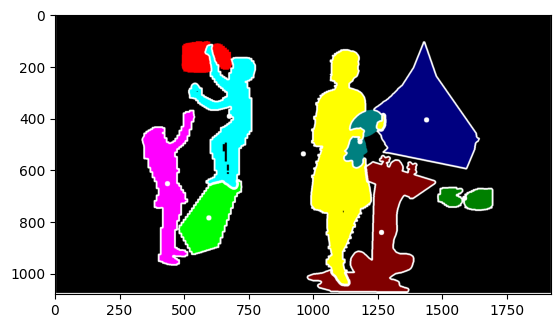

In [46]:
centroids = []
# Iterate over each unique color
for color in unique_colors:
    # Create a mask for the current color
    mask = cv2.inRange(image, color, color)
    
    # Find the contours of the masked region
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(image, contours, -1, (255,255,255), 5)
    # Compute the centroid of each contour
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            centroids.append((cX, cY, tuple(color)))
        else:
            centroids.append((0, 0, tuple(color)))
        print(centroids[-1])

print(centroids)
post_processed_centroids = {}
# Print the centroids
for idx, (cX, cY, color) in enumerate(centroids):
    print(f"Centroid of color {color}: ({cX}, {cY})")
    if post_processed_centroids.get(color) is not None:
        post_processed_centroids[color][0] += cX
        post_processed_centroids[color][1] += cY
        post_processed_centroids[color][0] /= 2
        post_processed_centroids[color][1] /= 2
        post_processed_centroids[color][0] = round(post_processed_centroids[color][0])
        post_processed_centroids[color][1] = round(post_processed_centroids[color][1])
    else:
        post_processed_centroids[color] = [cX, cY]

centroids = []
for color in list(post_processed_centroids.keys()):
    centroids.append((post_processed_centroids[color][0], post_processed_centroids[color][1], color))


# Optionally, draw the centroids on the image for visualization
for (cX, cY, color) in centroids:
    print(cX, cY, color)
    cv2.circle(image, (cX, cY), 10, (255, 255, 255), -1)

plt.imshow(image)
plt.show()

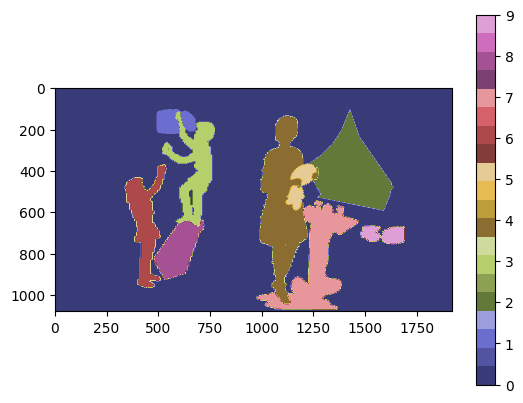

In [47]:
import matplotlib.pyplot as plt

plt.imshow(segmented_mask, cmap='tab20b')
plt.colorbar()
plt.show()


In [48]:
mask_id_list = np.unique(segmented_mask)
mask_id_list

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [49]:
# Cookie Theft, detailed version
# image_component_id_lookup = {
#     0: "Surrounding",
#     1: "Cookie Jar",
#     2: "Window",
#     3: "Boy",
#     4: "Lady's Head",
#     5: "Cookie"
#     6: "Lady's Body",
#     7: "Plate",
#     8: "Girl",
#     9: "Washing Cloth",
#     10: "Sink",
#     11: "Stool",
#     12: "Water",
#     13: "Dishes",
#     14: "Image Components"
# }

# Cookie Theft, concise version
# seperated_masks = {}
if task_name == "cookie":
    image_component_id_lookup = {
        0: "Surrounding",
        1: "Cookie Jar",
        2: "Window",
        3: "Boy",
        4: "Lady",
        5: "Plate, Washing Cloth",
        6: "Girl",
        7: "Sink, Water",
        8: "Stool",
        9: "Dishes",
        10: "Image Components"
    }
else:
# # Picnic
    image_component_id_lookup = {
        0: "Surrounding",
        1: "Tree, House, Car",
        2: "Kite",
        3: "Flag",
        4: "Boat",
        5: "Fishing",
        6: "Boy",
        7: "Lady",
        8: "Man",
        9: "Girl, Sand Castle",
        10: "Dog",
        11: "Glass, Beverage",
        12: "Book",
        13: "Basket",
        14: "Blanket",
        15: "Radio",
        16: "Sandals",
        17: "Image Components"
    }
seperated_masks = {}

In [50]:
for id in mask_id_list:
    isolated_mask = segmented_mask.copy()
    isolated_mask[isolated_mask != id] = -1
    print(f"id: {id}, tag: {image_component_id_lookup[id]}")
    print(np.unique(isolated_mask))
    seperated_masks[id] = isolated_mask
    # plt.imshow(seperated_masks[id], cmap='nipy_spectral')
    # plt.colorbar()
    # plt.show()

id: 0, tag: Surrounding
[-1  0]
id: 1, tag: Cookie Jar
[-1  1]
id: 2, tag: Window
[-1  2]
id: 3, tag: Boy
[-1  3]
id: 4, tag: Lady
[-1  4]
id: 5, tag: Plate, Washing Cloth
[-1  5]
id: 6, tag: Girl
[-1  6]
id: 7, tag: Sink, Water
[-1  7]
id: 8, tag: Stool
[-1  8]
id: 9, tag: Dishes
[-1  9]


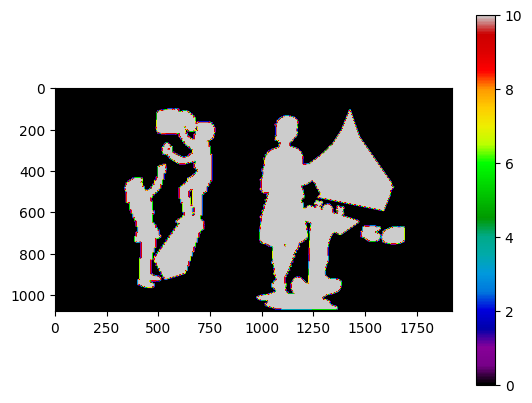

In [51]:
image_component_mask = segmented_mask.copy()
image_component_mask[image_component_mask != 0] = len(image_component_id_lookup) - 1
seperated_masks[len(image_component_id_lookup) - 1] = image_component_mask 
plt.imshow(seperated_masks[len(image_component_id_lookup) - 1], cmap='nipy_spectral')
plt.colorbar()
plt.show()

In [15]:
def get_pixel_coordinates(segmented_mask, label):
    # print(np.column_stack(np.where(segmented_mask == label)))
    image_component_mask = segmented_mask.copy()
    image_component_mask[image_component_mask != label] = -1
    # plt.imshow(image_component_mask, cmap='nipy_spectral')
    print(np.unique(segmented_mask))
    print(np.unique(image_component_mask))
    # plt.show()
    return np.column_stack(np.where(segmented_mask == label))

def fit_gmm_to_component(coordinates, n_components):
    gmm = GaussianMixture(n_components=n_components, covariance_type='full')
    gmm.fit(coordinates)
    return gmm

def compute_likelihoods(gmm, coordinates):
    return gmm.score_samples(coordinates)

In [16]:
param_grid = {
    'n_components': range(1, 2),
    'covariance_type': ['full', 'tied', 'diag', 'spherical'],
    # 'reg_covar': [1e-6, 1e-4, 1e-2, 1e-1]
}
def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)
hyperparameters = {}
for key in list(image_component_id_lookup.keys()):
    if key == 0:
        continue
    print(f"Searching: {key} - {image_component_id_lookup[key]}")
    # Define the GMM model
    gmm = GaussianMixture(random_state=0)
    grid_search = GridSearchCV(
        gmm, param_grid=param_grid, scoring=gmm_bic_score
    )
    # Perform GridSearchCV
    component_coords = get_pixel_coordinates(seperated_masks[key], key)
    grid_search.fit(component_coords)

    # Best parameters
    best_params = grid_search.best_params_
    hyperparameters[key] = best_params

    print(f'Best parameters: {best_params}')

Searching: 1 - Tree, House, Car
[-1  1]
[-1  1]
Best parameters: {'covariance_type': 'spherical', 'n_components': 1}
Searching: 2 - Kite
[-1  2]
[-1  2]
Best parameters: {'covariance_type': 'diag', 'n_components': 1}
Searching: 3 - Flag
[-1  3]
[-1  3]
Best parameters: {'covariance_type': 'diag', 'n_components': 1}
Searching: 4 - Boat
[-1  4]
[-1  4]
Best parameters: {'covariance_type': 'spherical', 'n_components': 1}
Searching: 5 - Fishing
[-1  5]
[-1  5]
Best parameters: {'covariance_type': 'spherical', 'n_components': 1}
Searching: 6 - Boy
[-1  6]
[-1  6]
Best parameters: {'covariance_type': 'full', 'n_components': 1}
Searching: 7 - Lady
[-1  7]
[-1  7]
Best parameters: {'covariance_type': 'diag', 'n_components': 1}
Searching: 8 - Man
[-1  8]
[-1  8]
Best parameters: {'covariance_type': 'diag', 'n_components': 1}
Searching: 9 - Girl, Sand Castle
[-1  9]
[-1  9]
Best parameters: {'covariance_type': 'spherical', 'n_components': 1}
Searching: 10 - Dog
[-1 10]
[-1 10]
Best parameters: {

In [ ]:
component_gmms = {}
gmm_means = []
gmm_covariances = []
gmm_weights = []
for key in list(image_component_id_lookup.keys()):
    if key == 0 or key == len(image_component_id_lookup) - 1:
        continue
    print(f"Fitting: {key} - {image_component_id_lookup[key]}")
    component_coords = get_pixel_coordinates(seperated_masks[key], key)
    component_coords[:, [0, 1]] = component_coords[:, [1, 0]]
    print(f"data: {component_coords}")
    gmm = fit_gmm_to_component(component_coords, hyperparameters[key]["n_components"])
    gmm_means.append(gmm.means_)
    gmm_covariances.append(gmm.covariances_)
    gmm_weights.append(gmm.weights_)
    component_gmms[image_component_id_lookup[key]] = gmm

In [ ]:
combined_means = np.vstack(gmm_means)
combined_covariances = np.vstack(gmm_covariances)
combined_weights = np.hstack(gmm_weights)
combined_weights /= np.sum(combined_weights)

combined_gmm = GaussianMixture(n_components=len(combined_means), covariance_type='full')
combined_gmm.means_ = combined_means
combined_gmm.covariances_ = combined_covariances
combined_gmm.weights_ = combined_weights
combined_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(combined_covariances)).transpose((0, 2, 1))

component_gmms[len(image_component_id_lookup) - 1] = combined_gmm

In [17]:
# color_iter = itertools.cycle(["navy", "c", "cornflowerblue", "gold", "darkorange"])


def plot_gmm(X, Y_, means, covariances, index, title, width, height):
    plt.figure(dpi=600)
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar) in enumerate(zip(means, covariances)):
        v, w = linalg.eigh(covar)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not (X is None or Y_ is None):
            if not np.any(Y_ == i):
                continue
            plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 0.8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180.0 * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], angle=180.0 + angle, color=plt.cm.tab20(i))
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    splot.set_aspect('equal', 'box')
    # splot.invert_yaxis()
    plt.xlim(0, width)
    plt.ylim(0, height)
    plt.gca().invert_yaxis()
    # plt.xticks(())
    # plt.yticks(())
    plt.title(title)
    plt.imshow(segmented_mask, cmap='Pastel2', alpha=1)

# Plot the combined GMM

x_max = 1920
y_max = 1080
# print(combined_gmm.means_)
# print(combined_gmm.covariances_)

plot_gmm(None, None, combined_gmm.means_, combined_gmm.covariances_, 0, 'GMM Components over Image Components', x_max, y_max)


NameError: name 'combined_gmm' is not defined

In [ ]:
def get_normalized_log_likelihood(filepath, x_scale, y_scale, gmm, show_plot=True, title=""):
    points = get_eye_gaze_data(filepath)
    points[:, 0] *= x_scale
    points[:, 1] *= y_scale
    log_llh = combined_gmm.score(points)
    # log_llh /= points.shape[0]
    if show_plot:
        fig, ax = plt.subplots()
        plt.scatter(points[:, 0], points[:, 1], marker='x', s=1)
        ax.set_aspect('equal', 'box')
        plt.title(title)
        plt.show()
    return log_llh

In [ ]:
# print("P02")
# print("S1:", get_normalized_log_likelihood("data/P02_S1_all_gaze.csv", x_max, y_max, combined_gmm, title="P02 S1"))
# print("S3:", get_normalized_log_likelihood("data/P02_S3_all_gaze.csv", x_max, y_max, combined_gmm, title="P02 S3"))
# print("S5:", get_normalized_log_likelihood("data/P02_S5 # Partial_all_gaze.csv", x_max, y_max, combined_gmm, title="P02 S5"))
# print("====================")
# # print("S2:", get_normalized_log_likelihood("data/P02_S2_all_gaze.csv", x_max, y_max, combined_gmm))
# # print("S4:", get_normalized_log_likelihood("data/P02_S4_all_gaze.csv", x_max, y_max, combined_gmm))

In [ ]:
# print("P07")
# print("S1:", get_normalized_log_likelihood("data/P07_S1_all_gaze.csv", x_max, y_max, combined_gmm, title="P07 S1"))
# print("S3:", get_normalized_log_likelihood("data/P07_S3_all_gaze.csv", x_max, y_max, combined_gmm, title="P07 S3"))
# print("S5:", get_normalized_log_likelihood("data/P07_S5_all_gaze.csv", x_max, y_max, combined_gmm, title="P07 S5"))
# print("====================")
# # print("S2:", get_normalized_log_likelihood("data/P07_S2_all_gaze.csv", x_max, y_max, combined_gmm))
# # print("S4:", get_normalized_log_likelihood("data/P07_S4_all_gaze.csv", x_max, y_max, combined_gmm))

In [ ]:
# print("P23")
# print("S1:", get_normalized_log_likelihood("data/P23_S1_all_gaze.csv", x_max, y_max, combined_gmm, title="P23 S1"))
# print("S3:", get_normalized_log_likelihood("data/P23_S3_all_gaze.csv", x_max, y_max, combined_gmm, title="P23 S3"))
# print("S5:", get_normalized_log_likelihood("data/P23_S5_all_gaze.csv", x_max, y_max, combined_gmm, title="P23 S5"))
# print("====================")
# # print("S2:", get_normalized_log_likelihood("data/P23_S2_all_gaze.csv", x_max, y_max, combined_gmm))
# # print("S4:", get_normalized_log_likelihood("data/P23_S4_all_gaze.csv", x_max, y_max, combined_gmm))

In [ ]:
# points = get_eye_gaze_data("data/P23_S1_all_gaze.csv")

# points[:, 0] *= x_max
# points[:, 1] *= y_max
# eye_gaze_gmm = fit_gmm_to_component(points, 10)

# plot_gmm(None, None, eye_gaze_gmm.means_, eye_gaze_gmm.covariances_, 0, 'Eye Gaze Data GMM', x_max, y_max)

In [ ]:
param_grid_eye_gaze = {
    'n_components': [1, 3, 5, 7, 9, 11],
    'covariance_type': ['full'],
    # 'reg_covar': [1e-6, 1e-4, 1e-2, 1e-1]
}

def search_parameter_eye_gaze(filepath, param_grid, scoring, x_scale=1920, y_scale=1080):    
    # Define the GMM model
    gmm = GaussianMixture(random_state=0)
    
    grid_search = GridSearchCV(
        gmm, param_grid=param_grid, scoring=scoring
    )
    # Perform GridSearchCV
    points = get_eye_gaze_data(filepath)
    points[:, 0] *= x_scale
    points[:, 1] *= y_scale
    
    grid_search.fit(points)
    
    # Best parameters
    best_params = grid_search.best_params_
    eye_gaze_gmm = fit_gmm_to_component(points, best_params["n_components"])
    
    plot_gmm(None, None, eye_gaze_gmm.means_, eye_gaze_gmm.covariances_, 0, 'Eye Gaze Data GMM', x_scale, y_scale)
    print(f'Best parameters: {best_params}')
    return best_params


In [ ]:
# search_parameter_eye_gaze("data/P02_S1_all_gaze.csv", param_grid_eye_gaze, gmm_bic_score)
# search_parameter_eye_gaze("data/P02_S3_all_gaze.csv", param_grid_eye_gaze, gmm_bic_score)
# search_parameter_eye_gaze("data/P02_S5 # Partial_all_gaze.csv", param_grid_eye_gaze, gmm_bic_score)

In [ ]:
# search_parameter_eye_gaze("data/P07_S1_all_gaze.csv", param_grid_eye_gaze, gmm_bic_score)
# search_parameter_eye_gaze("data/P07_S3_all_gaze.csv", param_grid_eye_gaze, gmm_bic_score)
# search_parameter_eye_gaze("data/P07_S5_all_gaze.csv", param_grid_eye_gaze, gmm_bic_score)

## Fit GMM with n_components = 17

[ 0 10]
[-1 10]


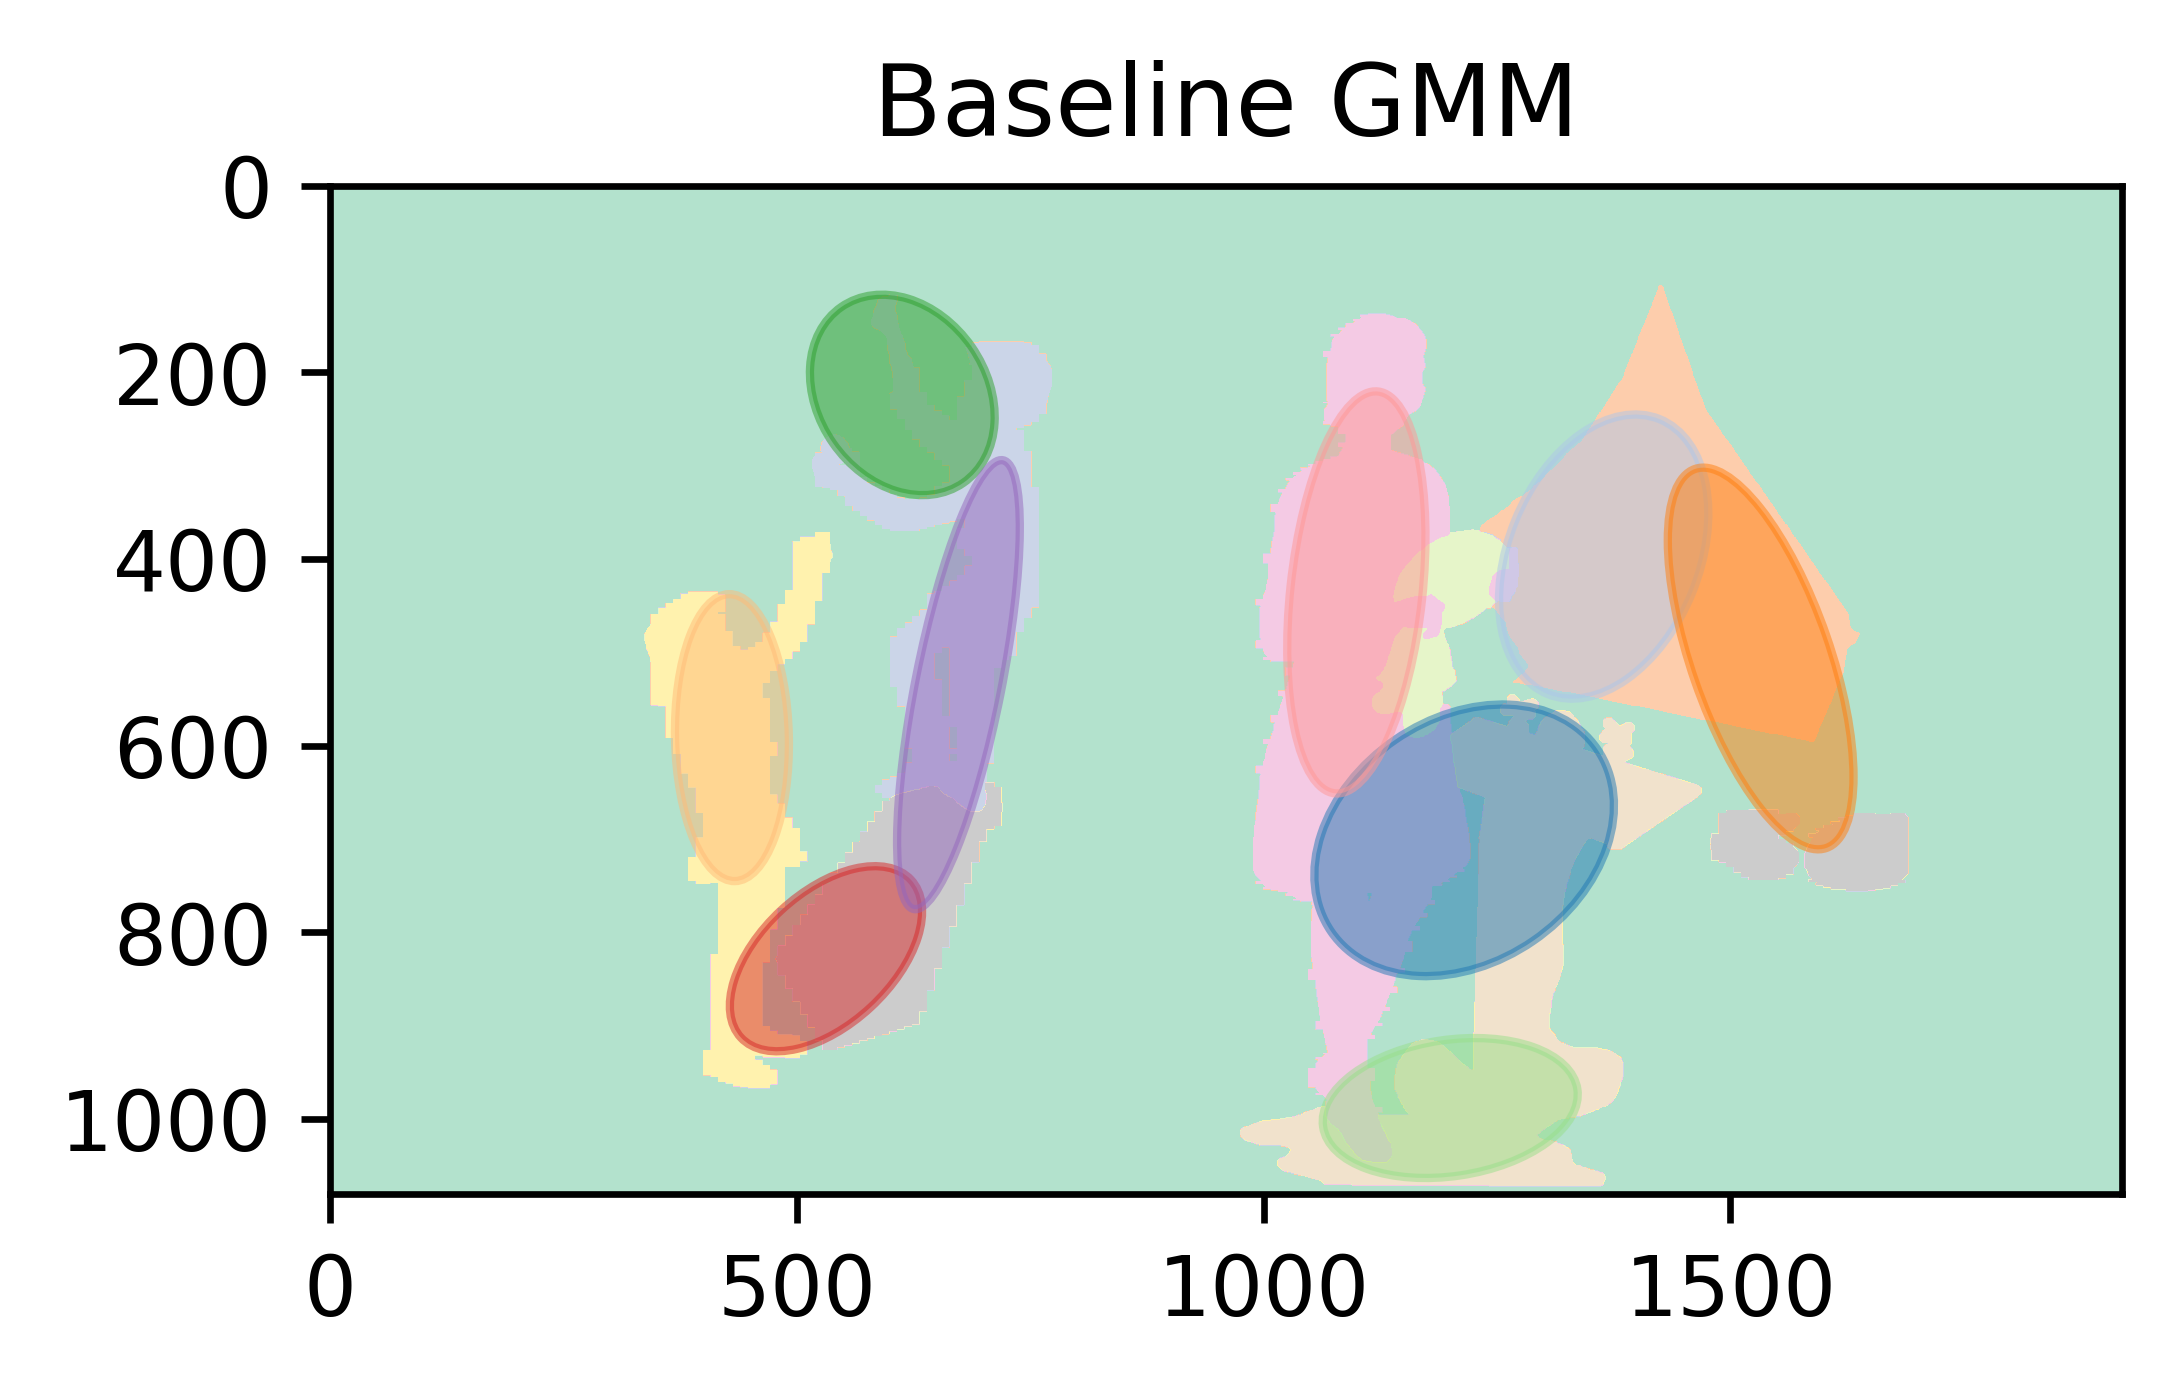

In [52]:
# seperated_masks[len(image_component_id_lookup) - 1]
if task_name == "cookie":
    num_components_baseline = 9
else:
    num_components_baseline = 16
gmm17 = GaussianMixture(random_state=0)

points = get_pixel_coordinates(seperated_masks[len(image_component_id_lookup) - 1], len(image_component_id_lookup) - 1)
points[:, 0] *= 1
points[:, 1] *= 1
points[:, [0, 1]] = points[:, [1, 0]]
gmm17 = fit_gmm_to_component(points, num_components_baseline)

plot_gmm(None, None, gmm17.means_, gmm17.covariances_, 0, 'Baseline GMM', 1920, 1080)

In [19]:
print(gmm17)

GaussianMixture(n_components=17)


In [26]:
gmm17.means_

array([[1306.57334053,  647.35419553],
       [ 423.81410215,  624.74504799],
       [ 587.11208634,  349.97948444],
       [1268.10500949,  990.19883314],
       [1115.67821116,  402.29093177],
       [1529.01456239,  466.94373117],
       [1076.43640119,  757.10952787],
       [1426.06922663,  283.05431021],
       [ 529.94240536,  834.63653459],
       [ 603.46947816,  179.06617522],
       [1105.25505504, 1013.1763035 ],
       [ 670.09049168,  548.76335642],
       [1129.11089648,  604.40947996],
       [1344.69555357,  441.97666811],
       [1592.36340471,  711.08014376],
       [1118.0124443 ,  213.43065413],
       [1274.14234548,  815.77053456]])

In [28]:
from GMM_analysis import get_eye_gaze_data, get_GMM_baseline, get_normalized_log_likelihood

P02


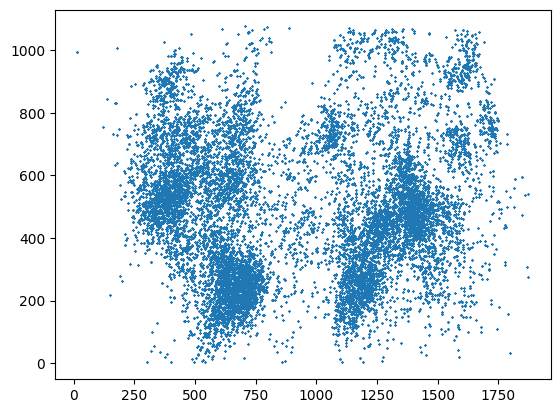

S1: -14.959739047096884


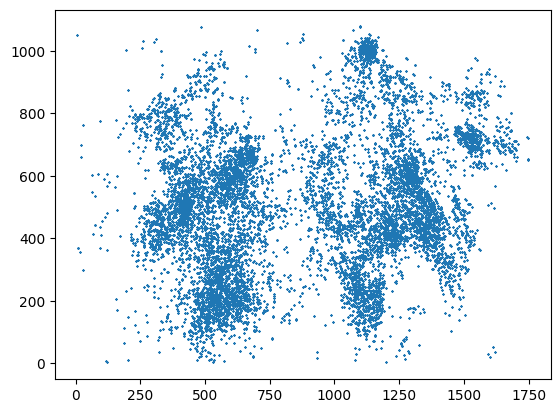

S3: -14.782983228634665


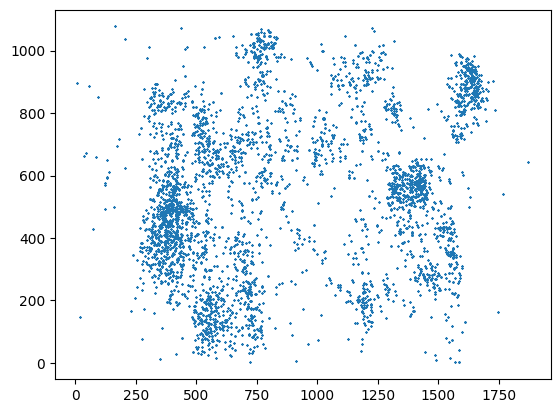

S5: -16.68575980520961


In [37]:
print("P02")
print("S1:", get_normalized_log_likelihood(get_eye_gaze_data("data/P02_S1_all_gaze.csv")[0], gmm17, x_max, y_max))
print("S3:", get_normalized_log_likelihood(get_eye_gaze_data("data/P02_S3_all_gaze.csv")[0], gmm17, x_max, y_max))
print("S5:", get_normalized_log_likelihood(get_eye_gaze_data("data/P02_S5 # Partial_all_gaze.csv")[0], gmm17, x_max, y_max))
print("====================")
# print("S2:", get_normalized_log_likelihood("data/P02_S2_all_gaze.csv", x_max, y_max, combined_gmm))
# print("S4:", get_normalized_log_likelihood("data/P02_S4_all_gaze.csv", x_max, y_max, combined_gmm))

In [33]:
points = get_eye_gaze_data("data/P02_S1_all_gaze.csv")[0]

array([[0.38293, 0.98561],
       [0.37326, 0.97533],
       [0.38717, 0.9321 ],
       ...,
       [0.29664, 0.26399],
       [0.33656, 0.30185],
       [0.34039, 0.31455]])

In [35]:
points[:, 0] *= 1920
points[:, 1] *= 1080

In [38]:
P02_S1 = get_eye_gaze_data("data/P02_S1_all_gaze.csv")[0]
P02_S3 = get_eye_gaze_data("data/P02_S3_all_gaze.csv")[0]

P02 = np.concatenate((P02_S1, P02_S3))

In [39]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

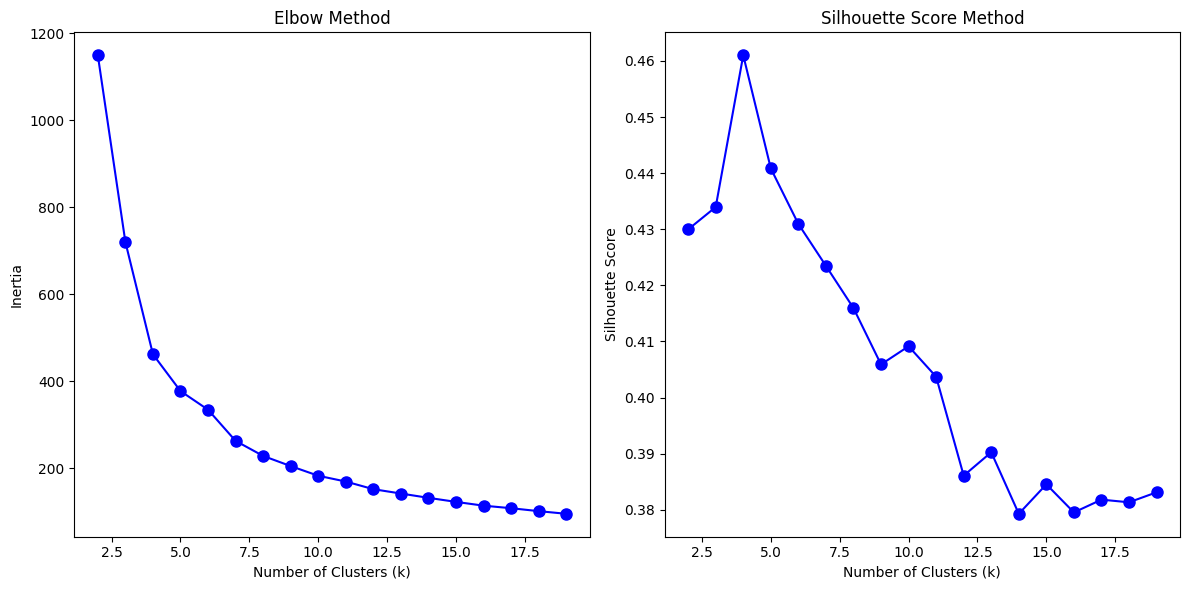

([0.4299694505361986,
  0.4339476822671042,
  0.46100207859412684,
  0.440833977932177,
  0.4309436141488781,
  0.4234755206543853,
  0.4159494697876249,
  0.40590479959705517,
  0.40914235405264265,
  0.40371360658802435,
  0.38608885207745736,
  0.390259069524048,
  0.3792921019525221,
  0.38454241696375674,
  0.3795370548065809,
  0.3818145712185412,
  0.3813411210566563,
  0.3831235168159184],
 [1149.351228123027,
  720.1493831678731,
  461.98349715771167,
  377.43831685346646,
  334.51793711473977,
  262.8755479058086,
  228.31587659007437,
  204.95796969019722,
  182.75649599991408,
  169.42751417497814,
  151.87326177639613,
  141.88552652376833,
  131.98681956329415,
  122.67017829722677,
  113.99419332662615,
  108.15426842213826,
  101.39796576185742,
  95.3164564975918])

In [40]:
inertia = []
silhouette_scores = []
K_range = range(2, 20)


for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(P02)
    inertia.append(kmeans.inertia_)
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(P02, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(K_range, inertia, 'bo-', markersize=8)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, 'bo-', markersize=8)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')

plt.tight_layout()
plt.show()

silhouette_scores, inertia

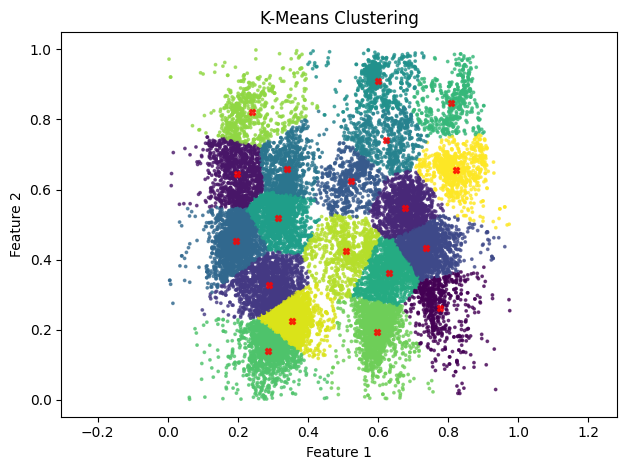

In [47]:

# plt.subplot(1, 2, 1)
# plt.scatter(P02[:, 0], P02[:, 1], c='gray', s=10, alpha=0.7)
# plt.title('Raw Scatter Plot')
# plt.xlabel('Feature 1')
# plt.ylabel('Feature 2')
# plt.axis('equal')

# plt.subplot(1, 2, 2)
plt.scatter(P02[:, 0], P02[:, 1], c=cluster_labels, cmap='viridis', s=3, alpha=0.7)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=20, alpha=0.75, marker='X')
plt.title('K-Means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.axis('equal')

plt.tight_layout()
plt.show()

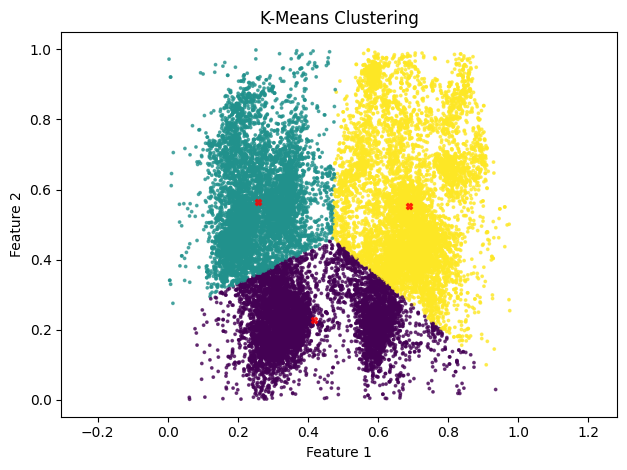

In [49]:
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(P02)
cluster_labels = kmeans.labels_
plt.scatter(P02[:, 0], P02[:, 1], c=cluster_labels, cmap='viridis', s=3, alpha=0.7)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=20, alpha=0.75, marker='X')
plt.title('K-Means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.axis('equal')

plt.tight_layout()
plt.show()